In [1]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import wget
from azure.storage.blob import ContainerClient

In [2]:
modis_account_name = 'modissa'
modis_container_name = 'modis-006'
modis_account_url = 'https://' + modis_account_name + '.blob.core.windows.net/'
modis_blob_root = modis_account_url + modis_container_name + '/'

In [3]:
modis_tile_extents_url = modis_blob_root + 'sn_bound_10deg.txt'

dir = os.path.join('../data','mod10a1')
os.makedirs(dir,exist_ok=True)
fn = os.path.join(dir,modis_tile_extents_url.split('/')[-1])
wget.download(modis_tile_extents_url, fn)

# Load this file into a table, where each row is (v,h,lonmin,lonmax,latmin,latmax)
modis_tile_extents = np.genfromtxt(fn,
                     skip_header = 7, 
                     skip_footer = 3)

modis_container_client = ContainerClient(account_url=modis_account_url, 
                                         container_name=modis_container_name,
                                         credential=None)

In [4]:
fn

'../data/mod10a1/sn_bound_10deg.txt'

In [5]:
modis_tile_extents.shape

(646, 6)

In [6]:
modis_container_client

In [7]:
def lat_lon_to_modis_tile(lat,lon):
    """
    Get the modis tile indices (h,v) for a given lat/lon
    
    https://www.earthdatascience.org/tutorials/convert-modis-tile-to-lat-lon/
    """
    
    found_matching_tile = False
    i = 0
    while(not found_matching_tile):
        #print(i)
        found_matching_tile = lat >= modis_tile_extents[i, 4] \
        and lat <= modis_tile_extents[i, 5] \
        and lon >= modis_tile_extents[i, 2] and lon <= modis_tile_extents[i, 3]
        i += 1
        
    v = int(modis_tile_extents[i-1, 0])
    h = int(modis_tile_extents[i-1, 1])
    
    return h,v


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_hdf_blobs_in_folder(container_name,folder_name):
    """"
    List .hdf files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.hdf')]
    return files             


In [8]:
# Files are stored according to:
#
# http://modissa.blob.core.windows.net/modis-006/[product]/[htile]/[vtile]/[year][day]/filename

# This is the MODIS surface reflectance product
product = 'MOD10A1'

# Let's look at the tile containing Chicago, IL, on May 15, 2019 (day of year 135)
h,v = lat_lon_to_modis_tile(37.07778, -118.72344)
daynum = '2019135'
folder = product + '/' + '{:0>2d}/{:0>2d}'.format(h,v) + '/' + daynum

# Find all HDF files from this tile on this day
filenames = list_hdf_blobs_in_folder(modis_container_name,folder)
print('Found {} matching file(s):'.format(len(filenames)))
for fn in filenames:
    print(fn)

# Work with the first returned URL
blob_name = filenames[0]

# Download to a temporary file
url = modis_blob_root + blob_name

filename = os.path.join(dir,blob_name.replace('/','_'))
if not os.path.isfile(filename):
    wget.download(url,filename)

Found 1 matching file(s):
MOD10A1/07/05/2019135/MOD10A1.A2019135.h07v05.006.2019149220243.hdf


In [9]:
filename

'../data/mod10a1/MOD10A1_07_05_2019135_MOD10A1.A2019135.h07v05.006.2019149220243.hdf'

In [12]:
import xarray as xr
import rioxarray as rxr
ds = rxr.open_rasterio('../data/mod10a1/MOD10A1_07_05_2019135_MOD10A1.A2019135.h07v05.006.2019149220243.hdf', masked = True)
list(ds.keys())

RasterioIOError: '../data/mod10a1/MOD10A1_07_05_2019135_MOD10A1.A2019135.h07v05.006.2019149220243.hdf' not recognized as a supported file format.

In [13]:
from pyhdf.SD import SD, SDC
ds = SD(filename, SDC.READ)

In [15]:
ds.info()

(7, 9)

In [28]:
ds.attributes()

{'HDFEOSVersion': 'HDFEOS_V2.19',
 'StructMetadata.0': 'GROUP=SwathStructure\nEND_GROUP=SwathStructure\nGROUP=GridStructure\n\tGROUP=GRID_1\n\t\tGridName="MOD_Grid_Snow_500m"\n\t\tXDim=2400\n\t\tYDim=2400\n\t\tUpperLeftPointMtrs=(-12231455.716333,4447802.078667)\n\t\tLowerRightMtrs=(-11119505.196667,3335851.559000)\n\t\tProjection=GCTP_SNSOID\n\t\tProjParams=(6371007.181000,0,0,0,0,0,0,0,0,0,0,0,0)\n\t\tSphereCode=-1\n\t\tGridOrigin=HDFE_GD_UL\n\t\tGROUP=Dimension\n\t\tEND_GROUP=Dimension\n\t\tGROUP=DataField\n\t\t\tOBJECT=DataField_1\n\t\t\t\tDataFieldName="NDSI_Snow_Cover"\n\t\t\t\tDataType=DFNT_UINT8\n\t\t\t\tDimList=("YDim","XDim")\n\t\t\t\tCompressionType=HDFE_COMP_DEFLATE\n\t\t\t\tDeflateLevel=9\n\t\t\tEND_OBJECT=DataField_1\n\t\t\tOBJECT=DataField_2\n\t\t\t\tDataFieldName="NDSI_Snow_Cover_Basic_QA"\n\t\t\t\tDataType=DFNT_UINT8\n\t\t\t\tDimList=("YDim","XDim")\n\t\t\t\tCompressionType=HDFE_COMP_DEFLATE\n\t\t\t\tDeflateLevel=9\n\t\t\tEND_OBJECT=DataField_2\n\t\t\tOBJECT=DataField_

In [19]:
datasets_dic = ds.datasets()

for idx,sds in enumerate(datasets_dic.keys()):
    print (idx,sds)


0 NDSI_Snow_Cover
1 NDSI_Snow_Cover_Basic_QA
2 NDSI_Snow_Cover_Algorithm_Flags_QA
3 NDSI
4 Snow_Albedo_Daily_Tile
5 orbit_pnt
6 granule_pnt


In [23]:
sds_obj = ds.select('NDSI_Snow_Cover')
data = sds_obj.get()
print(data)

[[239 239 239 ... 239 239 239]
 [239 239 239 ... 239 239 239]
 [239 239 239 ... 239 239 239]
 ...
 [239 239 239 ... 250   0   0]
 [239 239 239 ...   0   0   0]
 [239 239 239 ...   0   0   0]]


In [25]:
data.shape

(2400, 2400)

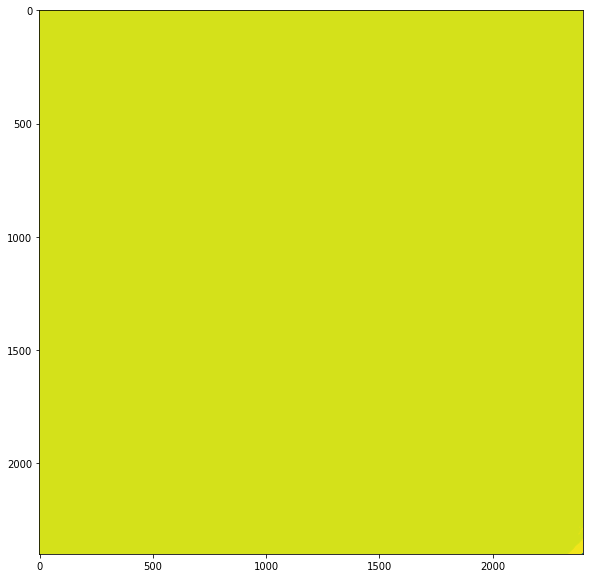

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.imshow(data)
plt.show()